# Fit a GP to SSN number using an sklearn GP

This is a leanring experiment, to demonstrate (quickly!?!) the basics of a GP. 

In [1]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np

## Read in the data

In [2]:
data_file = 'data/SSN/sunspot_data.csv'
df = pd.read_csv(data_file)
print(len(df))
df.head()

73718


,Unnamed: 0,Year,Month,Day,Date In Fraction Of Year,Number of Sunspots,Standard Deviation,Observations,Indicator
0,0,1818,1,1,1818.001,-1,-1.0,0,1
1,1,1818,1,2,1818.004,-1,-1.0,0,1
2,2,1818,1,3,1818.007,-1,-1.0,0,1
3,3,1818,1,4,1818.010,-1,-1.0,0,1
4,4,1818,1,5,1818.012,-1,-1.0,0,1


### Remove data with SSN = 0 or -1 

In [3]:
print(len(df))
df = df[df['Number of Sunspots'] > 0]
print(len(df))

73718
59370


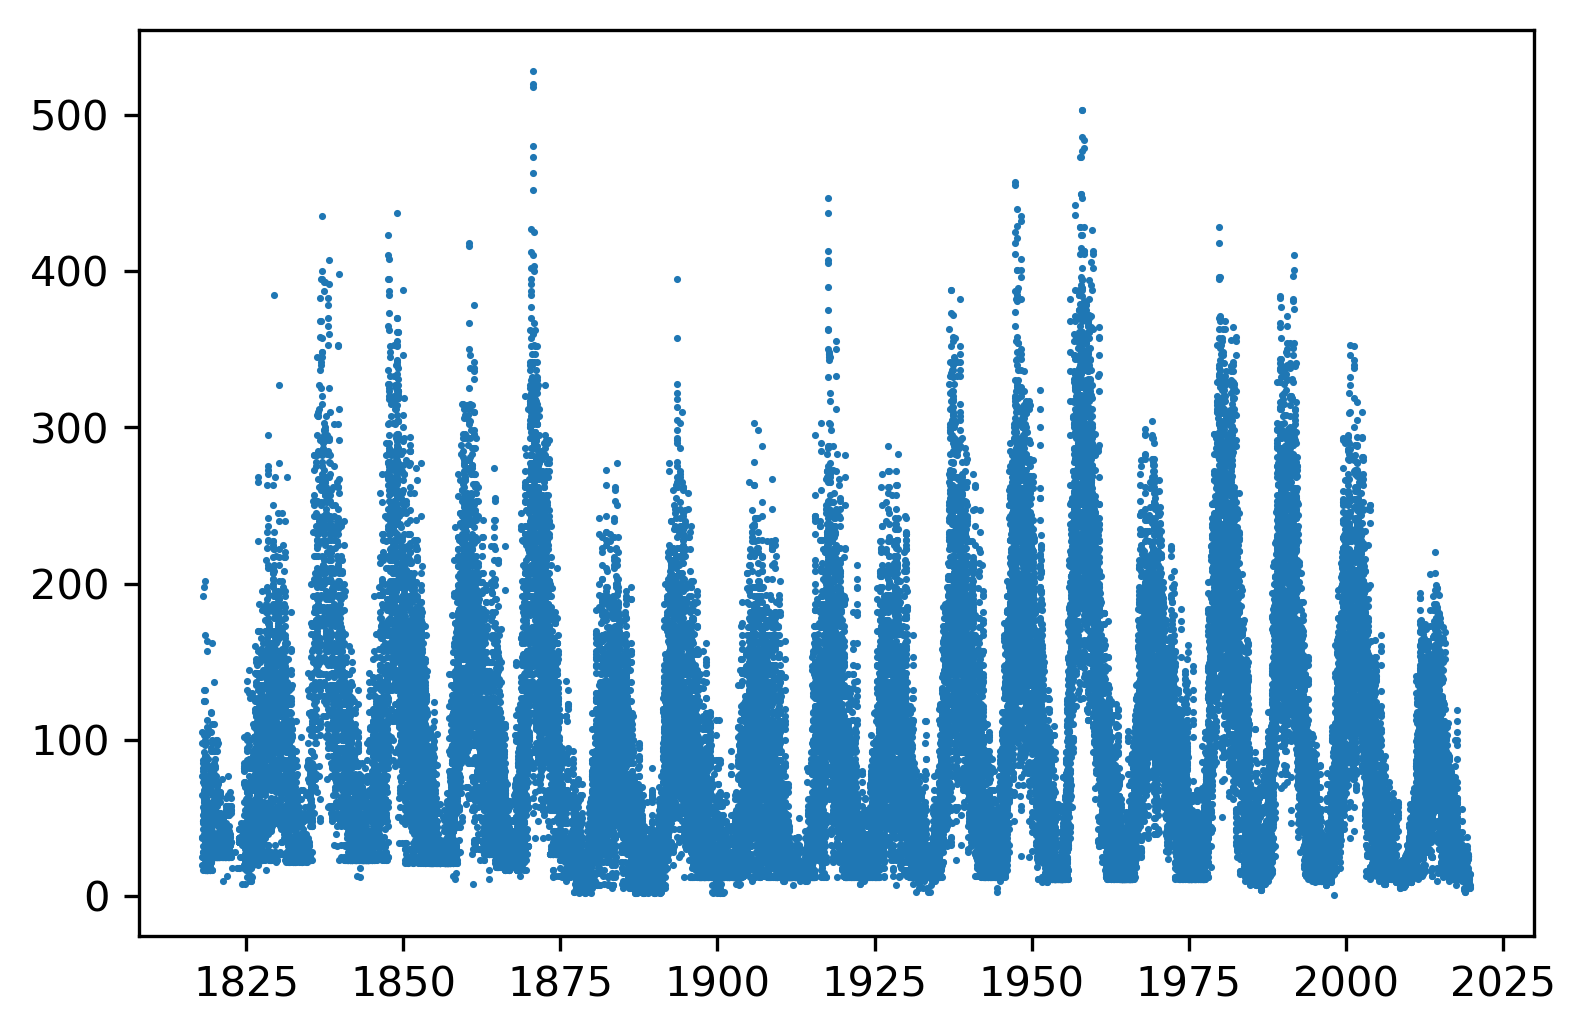

In [4]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(df['Date In Fraction Of Year'].values, 
           df['Number of Sunspots'], 
          s=1./2)

In [5]:
df_small = df.sample(frac=0.01)
print(len(df_small))

594


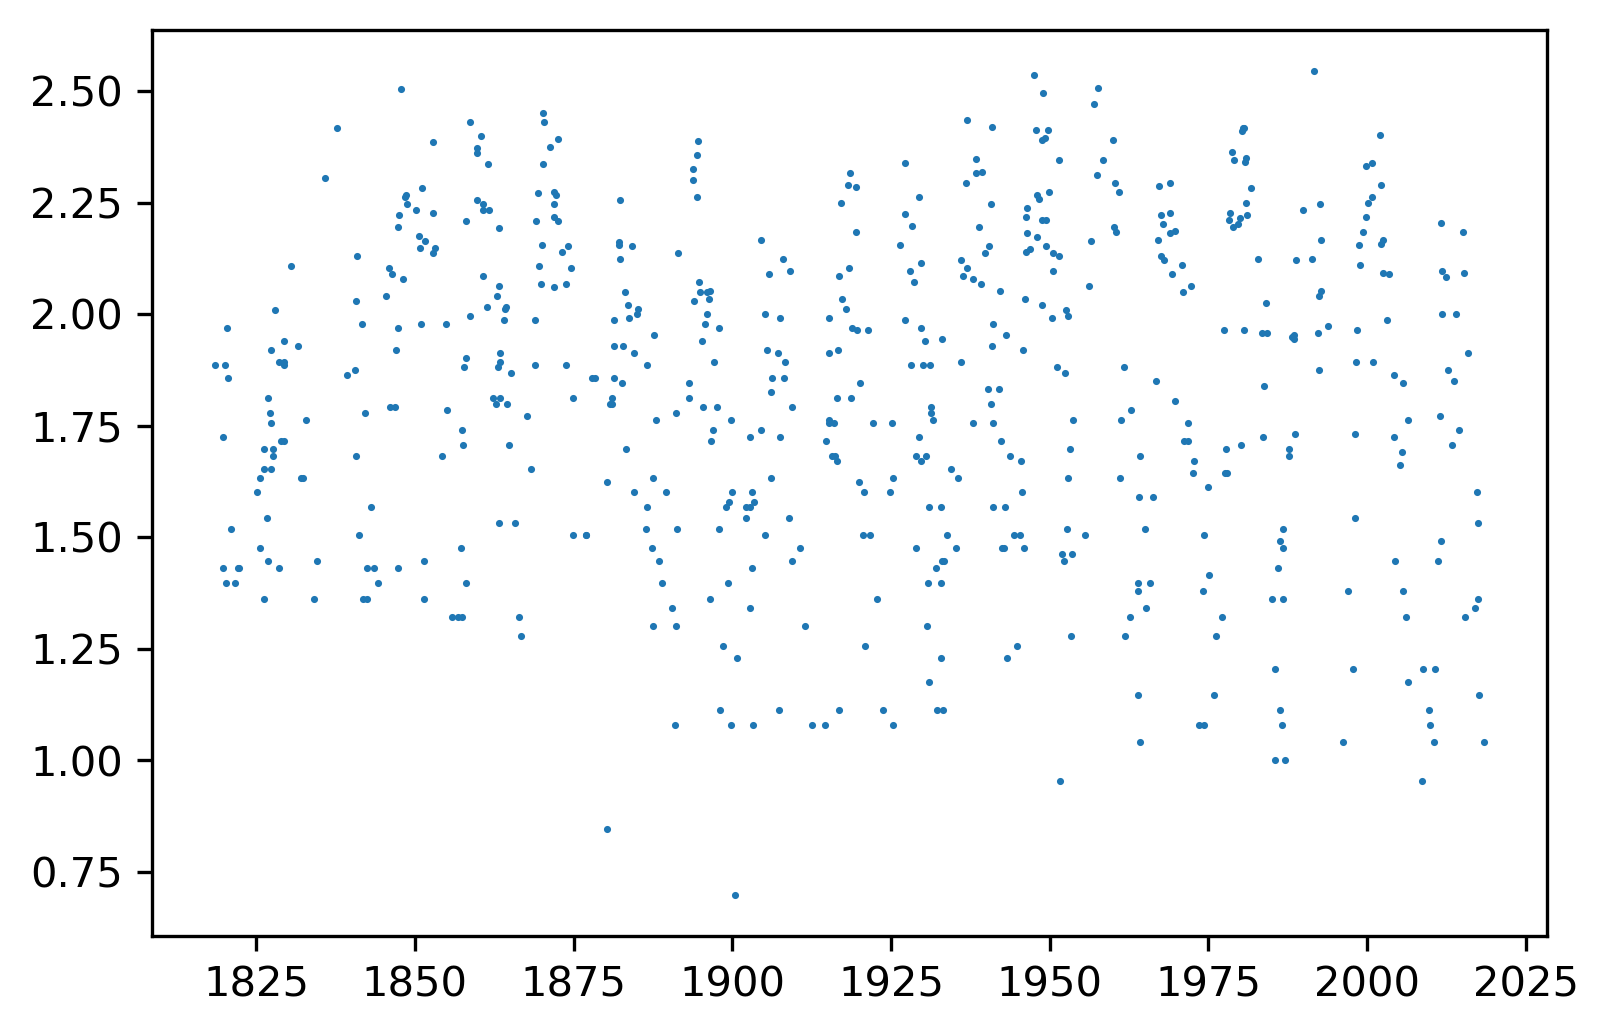

In [6]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(df_small['Date In Fraction Of Year'].values, 
           np.log10(df_small['Number of Sunspots'].values), 
          s=1./2)

In [7]:
X = df_small['Date In Fraction Of Year'].values[:, np.newaxis]
y = np.log10(df_small['Number of Sunspots'].values)

In [43]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF

seasonal_kernel = (
    4.0**2
    * RBF(length_scale=300.0,
         length_scale_bounds='fixed', )
    * ExpSineSquared(length_scale=300.0, periodicity=11.0, 
                     length_scale_bounds='fixed', 
                     periodicity_bounds=[10.0, 11.5])
)

qbo_kernel = (
    0.5**2
    * RBF(length_scale=100.0,
         length_scale_bounds='fixed', )
    * ExpSineSquared(length_scale=100.0, periodicity=2.0, 
                     length_scale_bounds='fixed', 
                     periodicity_bounds=[2.0, 2.6])
)

long_term_trend_kernel = 1.0**2 * RBF(length_scale=500.0, length_scale_bounds='fixed')



noise_kernel =  WhiteKernel(
    noise_level=0.2**2, noise_level_bounds=[0.01, 0.5]
)

kernel = seasonal_kernel + qbo_kernel + long_term_trend_kernel + noise_kernel

gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0, normalize_y=False).fit(X, y)

gpr.score(X, y)

0.4352176430189587

In [44]:
X_new = np.linspace(1818, 2050, 1000)[:, np.newaxis]
pred, std = gpr.predict(X_new, return_std=True)

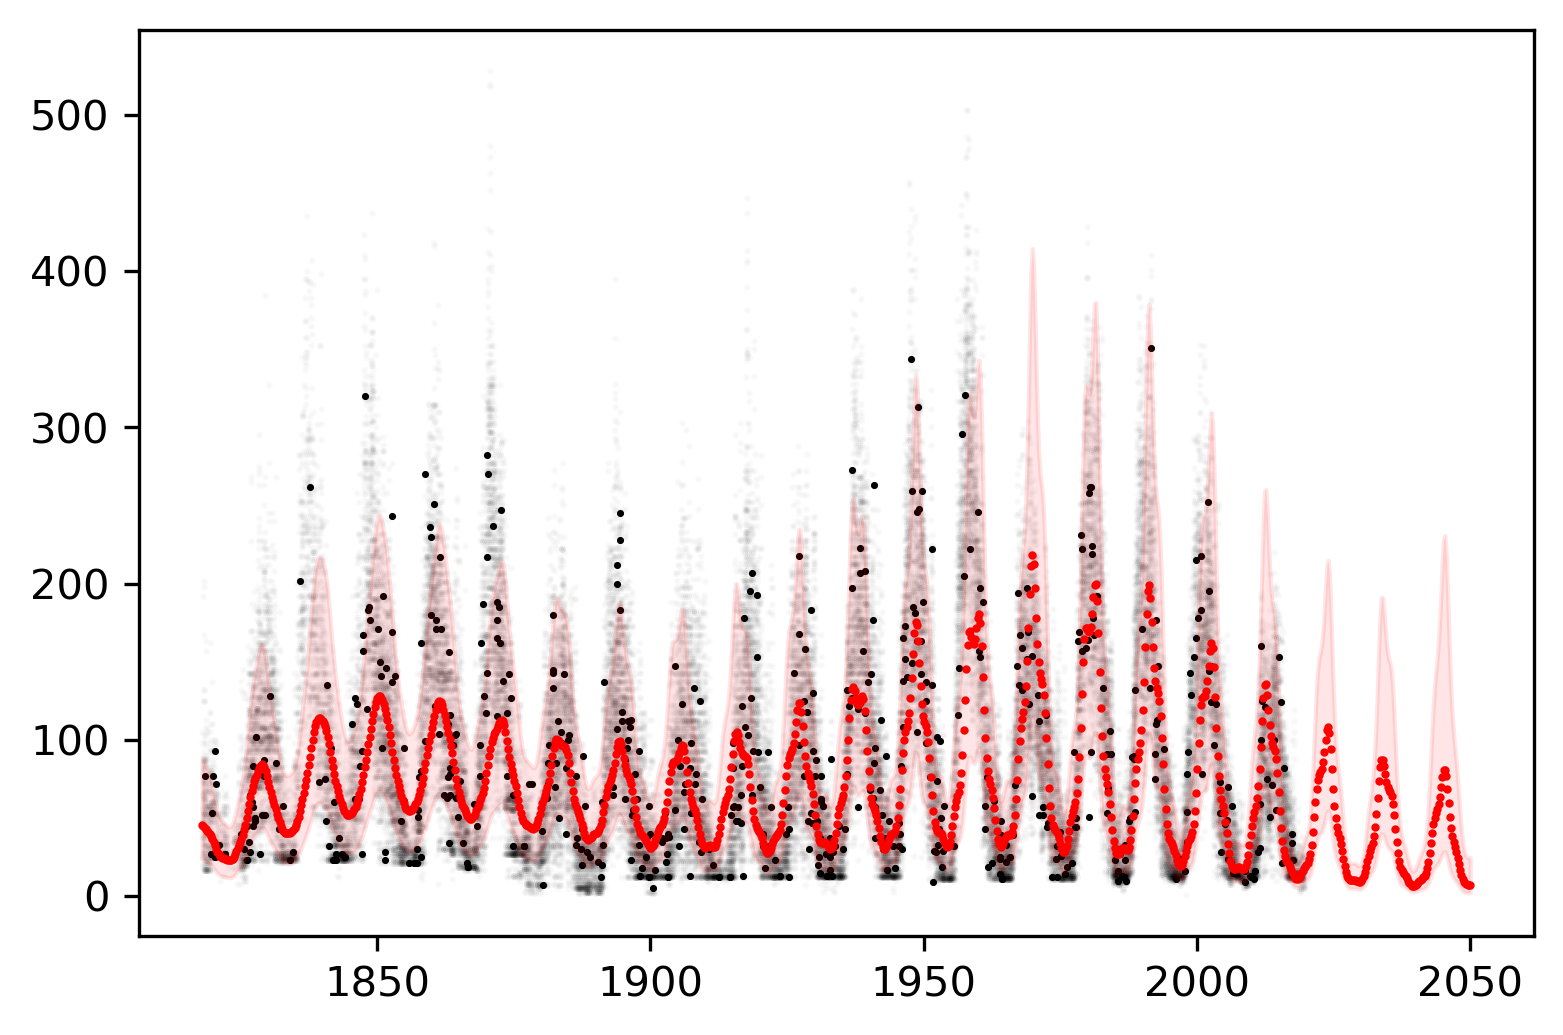

In [45]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(df_small['Date In Fraction Of Year'].values, 
           (df_small['Number of Sunspots'].values), 
          s=1./2, color='k')
ax.scatter(df['Date In Fraction Of Year'].values, 
           (df['Number of Sunspots'].values), 
          s=1./2, alpha=0.02, color='k')
ax.scatter(X_new, 10**pred, s=1., color='r')
ax.fill_between(X_new[:, 0], 10**(pred+std), 10**(pred-std), color='r', alpha=0.1)

In [46]:
gpr.kernel_

115**2 * RBF(length_scale=300) * ExpSineSquared(length_scale=300, periodicity=10.7) + 4.06**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=100, periodicity=2.36) + 0.997**2 * RBF(length_scale=500) + WhiteKernel(noise_level=0.0764)